In [3]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
# from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from sklearn.model_selection import train_test_split

import tqdm

import warnings

In [4]:
from utils import read_txn_data, preprocess_txn_data, compute_lob_features, create_lob_dataset, merge_txn_and_lob

In [5]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

In [6]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

### Data Loading

In [7]:
trx_df = read_txn_data(use_load=False)
trx_df = preprocess_txn_data(trx_df, freq='1min')
trx_df['log_deseasoned_total_volume'] = np.log(trx_df['deseasoned_total_volume'] + 1e-07)

lob_df = create_lob_dataset(use_load=False)

df_merged = merge_txn_and_lob(trx_df, lob_df)
df_merged.head()

trx Data loaded successfully.
preprocessed lob Data loaded successfully.


,datetime,buy_volume,sell_volume,buy_txn,sell_txn,volume_imbalance,txn_imbalance,total_volume,mean_volume,deseasoned_total_volume,log_deseasoned_total_volume,ask_volume,bid_volume,ask_slope_1,ask_slope_5,ask_slope_10,bid_slope_1,bid_slope_5,bid_slope_10,spread,lob_volume_imbalance,slope_imbalance_1,slope_imbalance_5,slope_imbalance_10
5819,2018-06-04 22:00:05+00:00,0.059804,0.730357,5.0,10.0,0.670553,5.0,0.790162,4.380444,0.180384,-1.712667,2695.804973,586356.113693,1761.630667,2695.804973,2695.804973,3.972121,53.502450,160.246934,6.19,583660.308720,1757.658546,2642.302523,2535.558040
5820,2018-06-04 22:01:05+00:00,0.089359,0.849477,3.0,4.0,0.760118,1.0,0.938836,3.692009,0.254289,-1.369285,2699.165417,586350.938081,1765.312385,2699.165417,2699.165417,4.017044,52.408273,155.071322,4.97,583651.772664,1761.295341,2646.757144,2544.094095
5821,2018-06-04 22:02:05+00:00,0.313458,0.508952,2.0,4.0,0.195494,2.0,0.822410,3.324900,0.247349,-1.396955,2657.946212,586317.596946,1723.843180,2657.946212,2657.946212,3.831055,46.578294,158.194750,4.90,583659.650734,1720.012125,2611.367918,2499.751462
5822,2018-06-04 22:03:05+00:00,0.000992,0.199219,1.0,4.0,0.198227,3.0,0.200211,4.128645,0.048493,-3.026331,2650.599402,586308.612876,1718.061157,2650.599402,2650.599402,3.631836,51.036074,160.641345,4.32,583658.013474,1714.429321,2599.563327,2489.958056
5823,2018-06-04 22:04:05+00:00,0.172042,0.000000,7.0,0.0,0.172042,7.0,0.172042,6.271124,0.027434,-3.595966,2650.082079,586314.173248,1715.979046,2650.082079,2650.082079,3.704804,51.092926,160.489197,4.32,583664.091169,1712.274243,2598.989153,2489.592882


### ARMA-GARCH

In [5]:
# start = time.time()
# best_model = pmdarima.auto_arima(train_data['Price'],                                    
#                                  seasonal=False, stationary=False, 
#                                  m=7, information_criterion='aic', 
#                                  max_order=20,                                     
#                                  max_p=10, max_d=2, max_q=10,                                     
#                                  max_P=10, max_D=2, max_Q=10,                                   
#                                  error_action='ignore')
# print("best model --> (p, d, q):", best_model.order)
# elapsed_time = time.time() - start
# print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [ ]:
# Ensure the column is a series and drop missing values

## Runs 4 hours

# series = trx_df['log_deseasoned_total_volume'].dropna()

# # Split data into 80% train, 20% test
# train_size = int(0.8 * len(series))
# train, test = series[:train_size], series[train_size:]

# # Step 1: Search for the best (p, q) based on AIC
# def find_best_arma(train_series, p_range=(0, 5), q_range=(0, 5)):
#     best_aic = np.inf
#     best_order = None
#     aic_dict = {}
#     for p, q in tqdm.tqdm(product(range(p_range[0], p_range[1] + 1), range(q_range[0], q_range[1] + 1)), total=len(range(p_range[0], p_range[1] + 1)) * len(range(q_range[0], q_range[1] + 1))):
#         if p == 0 and q == 0:
#             continue  # Skip ARMA(0,0)
#         try:
#             model = ARIMA(train_series, order=(p, 0, q))
#             result = model.fit()
#             aic_dict[(p, q)] = result.aic
#             if result.aic < best_aic:
#                 best_aic = result.aic
#                 best_order = (p, q)
#         except:
#             continue  # Skip models that fail to converge
#     return aic_dict, best_order

# aic_dict, best_order = find_best_arma(train, (0, 8), (0, 8))
# best_p, best_q = best_order
# print(f"Optimal ARMA order: ({best_p}, {best_q})")



 21%|██        | 17/81 [10:43<1:29:34, 83.98s/it]c:\Users\aliak\my_space\ETH\ML Complex Systems\MLFCS\ML_fin_project\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 26%|██▌       | 21/81 [19:07<1:55:05, 115.09s/it]c:\Users\aliak\my_space\ETH\ML Complex Systems\MLFCS\ML_fin_project\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|██▋       | 22/81 [23:17<2:32:47, 155.37s/it]c:\Users\aliak\my_space\ETH\ML Complex Systems\MLFCS\ML_fin_project\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 35%|███▍      | 28/8

Optimal ARMA order: (6, 7)


In [8]:
series = trx_df['log_deseasoned_total_volume'].dropna()

train_size = int(0.8 * len(series))
train, test = series[:train_size], series[train_size:]

best_p, best_q = 6, 7

# Step 2: Fit ARMA-GARCH(1,1) model on train set
arma_model = ARIMA(train, order=(best_p, 0, best_q)).fit(method_kwargs={"solver": "lbfgs", "maxiter": 500})
residuals = arma_model.resid  # Get ARMA residuals

In [9]:
print(arma_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:     log_deseasoned_total_volume   No. Observations:               140592
Model:                          ARIMA(6, 0, 7)   Log Likelihood             -332117.992
Date:                         Tue, 15 Apr 2025   AIC                         664265.984
Time:                                 00:59:09   BIC                         664413.788
Sample:                                      0   HQIC                        664310.163
                                      - 140592                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8381      0.211     -8.718      0.000      -2.251      -1.425
ar.L1         -0.8359      0.114     -7.325      0.000     

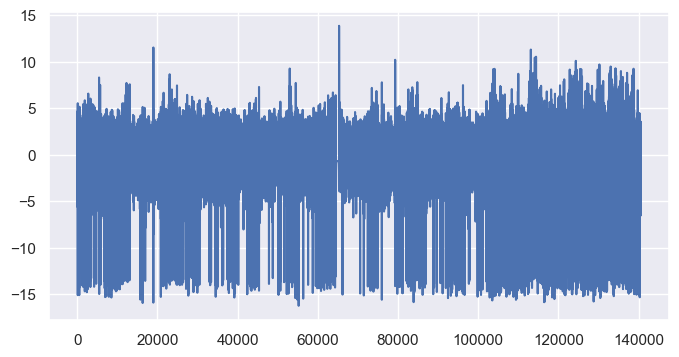

In [10]:
plt.plot(residuals)

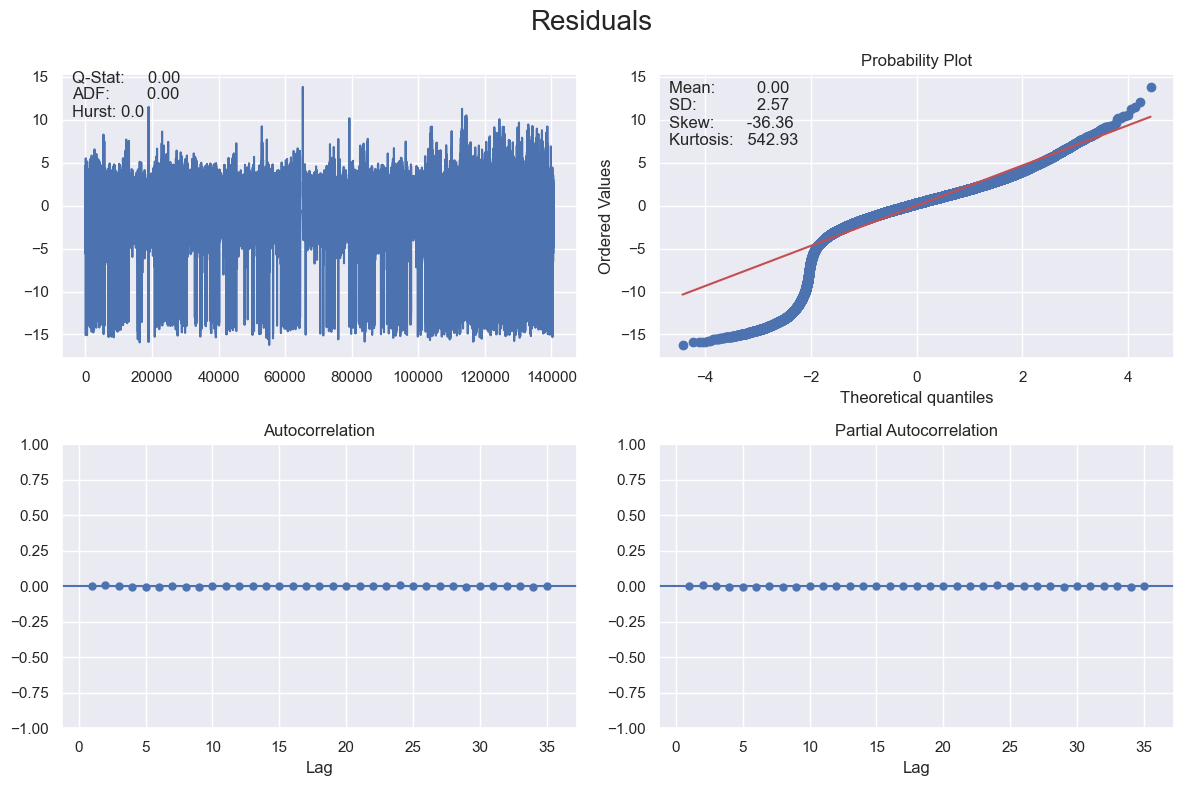

In [11]:
# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(residuals, lags=35, title='Residuals')

In [12]:
garch_model = arch_model(residuals, vol="Garch", p=1, q=1, mean="zero")
garch_result = garch_model.fit(options={"maxiter": 500})#disp="off", 


Iteration:      1,   Func. Count:      5,   Neg. LLF: 18060521.37780788
Iteration:      2,   Func. Count:     12,   Neg. LLF: 311816.6323345989
Iteration:      3,   Func. Count:     17,   Neg. LLF: 309936.06729372387
Iteration:      4,   Func. Count:     21,   Neg. LLF: 540603.9392901794
Iteration:      5,   Func. Count:     26,   Neg. LLF: 2358627084.59179
Iteration:      6,   Func. Count:     31,   Neg. LLF: 332665.7675969684
Iteration:      7,   Func. Count:     41,   Neg. LLF: 309537.7034315515
Iteration:      8,   Func. Count:     46,   Neg. LLF: 432377.5032094656
Iteration:      9,   Func. Count:     51,   Neg. LLF: 322149.30189314263
Iteration:     10,   Func. Count:     58,   Neg. LLF: 309650.6473271437
Iteration:     11,   Func. Count:     63,   Neg. LLF: 309494.32475228567
Iteration:     12,   Func. Count:     68,   Neg. LLF: 309493.34108890453
Iteration:     13,   Func. Count:     72,   Neg. LLF: 309493.3391747844
Iteration:     14,   Func. Count:     76,   Neg. LLF: 309493.

In [13]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -309493.
Distribution:                  Normal   AIC:                           618993.
Method:            Maximum Likelihood   BIC:                           619022.
                                        No. Observations:               140592
Date:                Tue, Apr 15 2025   Df Residuals:                   140592
Time:                        01:03:24   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0113  2.034e-03      5.544  2.957e-08 [7.

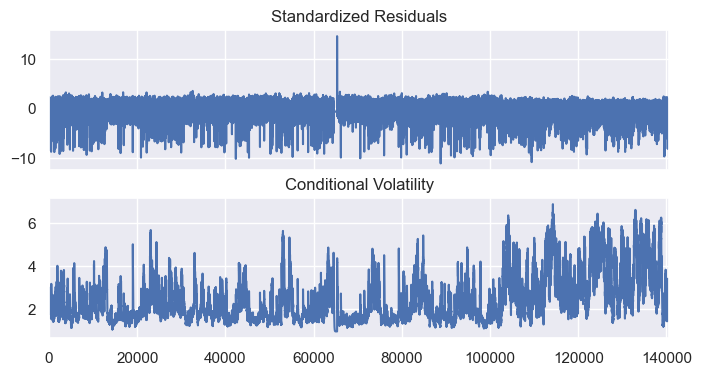

In [14]:
# Plot fitted results
garch_result.plot()
plt.show()

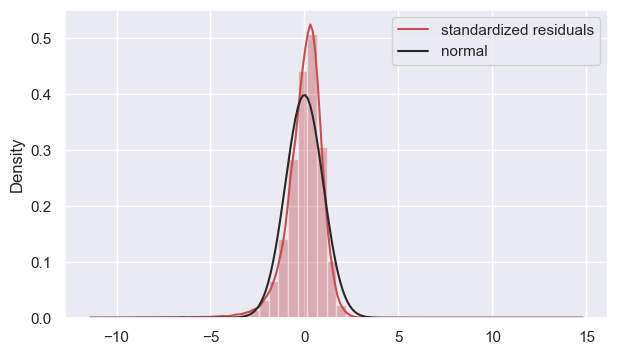

In [15]:
# Obtain model estimated residuals and volatility
gm_resid = garch_result.resid
gm_std = garch_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('standardized residuals', 'normal'))
plt.show()

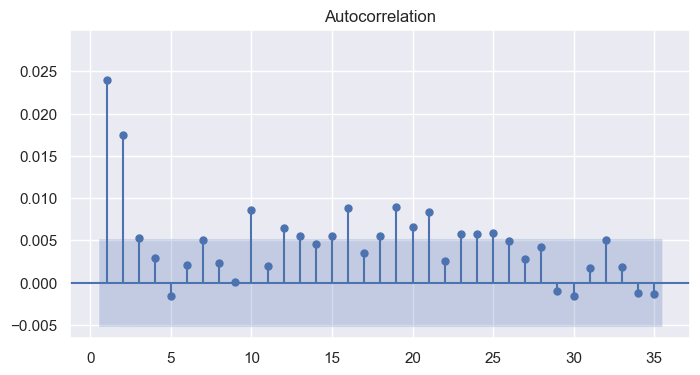

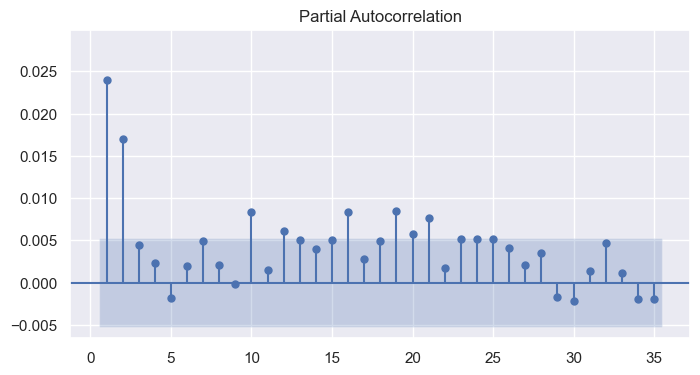

In [16]:
plot_acf(gm_std_resid, lags=35, zero=False, auto_ylims=True);
plot_pacf(gm_std_resid, lags=35, zero=False, auto_ylims=True);

In [17]:
# Step 3: Forecast using ARMA-GARCH
forecast_horizon = len(test)
arma_forecast = arma_model.forecast(steps=forecast_horizon)
garch_forecast = garch_result.forecast(horizon=forecast_horizon)

# Extract variance predictions (volatility forecasts)
predicted_volatility = np.sqrt(garch_forecast.variance.values[-1, :])  # Last row, all forecast steps

# Combine ARMA mean predictions with GARCH variance predictions
predictions = pd.DataFrame({
    "ARMA_Mean": arma_forecast.values,
    "GARCH_Volatility": predicted_volatility
}, index=test.index)

print(predictions.head())

        ARMA_Mean  GARCH_Volatility
140592  -0.406920          1.748324
140593  -0.323503          1.750559
140594  -0.365253          1.752789
140595  -0.362117          1.755013
140596  -0.350230          1.757232


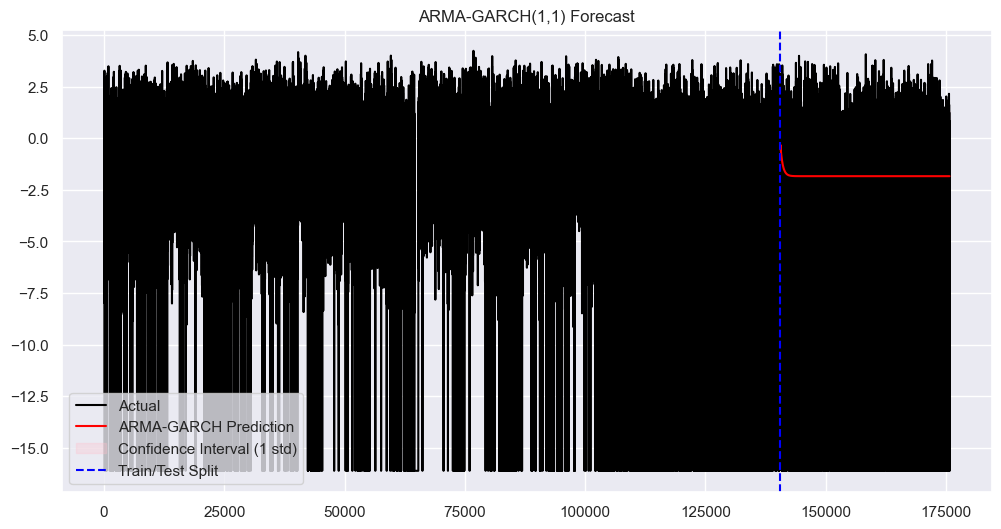

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(series.index, series, label="Actual", color="black")
plt.plot(test.index, predictions["ARMA_Mean"], label="ARMA-GARCH Prediction", color="red")
plt.fill_between(test.index, 
                 predictions["ARMA_Mean"] - predictions["GARCH_Volatility"],
                 predictions["ARMA_Mean"] + predictions["GARCH_Volatility"], 
                 color='pink', alpha=0.3, label="Confidence Interval (1 std)")
plt.axvline(x=series.index[train_size], color="blue", linestyle="--", label="Train/Test Split")
plt.legend()
plt.title("ARMA-GARCH(1,1) Forecast")
plt.show()


### Prediction

In [20]:
print(garch_result.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -309493.
Distribution:                  Normal   AIC:                           618993.
Method:            Maximum Likelihood   BIC:                           619022.
                                        No. Observations:               140592
Date:                Tue, Apr 15 2025   Df Residuals:                   140592
Time:                        01:03:24   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0113  2.034e-03      5.544  2.957e-08 [7.

In [19]:
print(arma_model.summary())

                                    SARIMAX Results                                    
Dep. Variable:     log_deseasoned_total_volume   No. Observations:               140592
Model:                          ARIMA(6, 0, 7)   Log Likelihood             -332117.992
Date:                         Tue, 15 Apr 2025   AIC                         664265.984
Time:                                 01:04:26   BIC                         664413.788
Sample:                                      0   HQIC                        664310.163
                                      - 140592                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8381      0.211     -8.718      0.000      -2.251      -1.425
ar.L1         -0.8359      0.114     -7.325      0.000     

In [32]:
for index, value in zip(arma_model.params.index, arma_model.params):
    print(index, value)

const -1.8380898700690314
ar.L1 -0.8359018382122737
ar.L2 0.7095702998193169
ar.L3 1.5643994563702182
ar.L4 0.8862103000056955
ar.L5 -0.588004985840683
ar.L6 -0.7391899835341238
ma.L1 1.0313041188346148
ma.L2 -0.422878039221242
ma.L3 -1.4918158357883016
ma.L4 -1.093452487703487
ma.L5 0.31920540371834255
ma.L6 0.6698164884298873
ma.L7 0.04979503730496893
sigma2 6.597558195107865


In [33]:
'ma.L7'.split('ma.L')

['', '7']

In [24]:
garch_result.params

omega       0.011279
alpha[1]    0.022583
beta[1]     0.976285
Name: params, dtype: float64

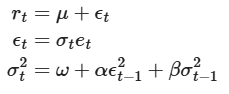

In [39]:
aaa =[1,2,3]
aaa = aaa[1:] + [4]
print(aaa)

[2, 3, 4]


In [42]:
def construct_1step_ARMA_pred(returns, resids, coefs):
    ar_part = 0
    ma_part = 0

    for index, coef in zip(coefs.index, coefs):
        if 'ma.L' in index:
            lag = int(index.split('ma.L')[-1])
            ma_part += resids[-lag]*coef
        
        elif 'ar.L' in index:
            lag = int(index.split('ar.L')[-1])
            ar_part += returns[-lag]*coef

    return coefs['const'] + ma_part + ar_part

returns_lagged = list(arma_model.fittedvalues[-6:].values)
resids_lagged = list(arma_model.resid[-7:].values)

preds = []
for test_value in tqdm.tqdm(test.values):
    pred = construct_1step_ARMA_pred(returns_lagged, resids_lagged, arma_model.params)
    preds.append(pred)
    returns_lagged = returns_lagged[1:] + [test_value]
    resids_lagged = resids_lagged[1:] + [test_value - pred]

100%|██████████| 35148/35148 [00:02<00:00, 13357.86it/s]


In [35]:
arma_model.fittedvalues[-6:].values

array([-0.81285888, -0.98507074, -0.5499236 , -0.23153496, -0.21358106,
       -0.14898529])

In [26]:
arma_model.resid

0         2.477938
1        -3.113523
2        -3.192030
3        -1.729154
4         1.573321
            ...   
140587    1.550120
140588    1.903715
140589    0.685599
140590    0.748049
140591   -0.932248
Length: 140592, dtype: float64

In [28]:
garch_result.conditional_volatility

0         2.177256
1         2.185856
2         2.212433
3         2.240571
4         2.231571
            ...   
140587    1.787965
140588    1.785091
140589    1.790002
140590    1.774828
140591    1.760463
Name: cond_vol, Length: 140592, dtype: float64